**Table of contents**<a id='toc0_'></a>    
- [中断時系列分析をする](#toc1_)    
  - [データ準備](#toc1_1_)    
  - [分析](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

from MLBDataFetcher import MLBDataFetcher
from preprocess import Att_Analysis
from InterruptedTimeSeries import ITS, MITS

/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <a id='toc1_'></a>[中断時系列分析をする](#toc0_)

## <a id='toc1_1_'></a>[データ準備](#toc0_)

In [2]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True)
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()

## <a id='toc1_2_'></a>[分析](#toc0_)

In [4]:
its_periodical_OLS = MITS(df_att_remove_covid_addup, interventions=['2022-04','2023-04'], method='Periodic OLS', optim_params_periodic_ols=True)
its_periodical_OLS.show_summary()

最適化されたパラメータ: period=6, order=3
VIF: [5.412946428571427, 2.190380489026994, 10.133333333333342, 35.09115646258506, 9.014965986394559, 9.46666666666666, 1.1603316326530602, 1.0534438775510209, 1.01781462585034, 1.0534438775510209, 1.319814379516164, 1.0267219387755102]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     12.28
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           1.10e-09
Time:                        16:37:29   Log-Likelihood:                -782.76
No. Observations:                  54   AIC:                             1588.
Df Residuals:                      43   BIC:                             1609.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.259e+07   1.69e+05     74.280      0.000    1.22e+07    1.29e+07
time since start -2.562e+04   6882.200     -3.723      0.001   -3.95e+04   -1.17e+04
level change 0   -2.577e+06   5.58e+05     -4.622      0.000    -3.7e+06   -1.45e+06
slope change 0    5.473e+05   1.37e+05      4.001      0.000    2.71e+05    8.23e+05
level change 1   -3.208e+05   6.96e+05     -0.461      0.647   -1.72e+06    1.08e+06
slope change 1   -5.078e+05   1.81e+05     -2.807      0.007   -8.73e+05   -1.43e+05
sin(1,6)          -1.43e+05   1.11e+05     -1.289      0.204   -3.67e+05    8.08e+04
cos(1,6)         -5.394e+05   1.06e+05     -5.102      0.000   -7.53e+05   -3.26e+05
sin(2,6)          1.848e+04   1.04e+05      0.178      0.860   -1.91e+05    2.28e+05
cos(2,6)         -4.893e+05   1.06e+05     -4.628      0.000   -7.02e+05   -2.76e+05
sin(3,6)          6.138e-09   2.85e-09      2.156      0.037    3.96e-10    1.19e-08
cos(3,6)         -4.146e+04   7.38e+04     -0.562      0.577    -1.9e+05    1.07e+05
==============================================================================
Omnibus:                        6.920   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.359
Skew:                          -0.494   Prob(JB):                       0.0252
Kurtosis:                       4.515   Cond. No.                     4.02e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

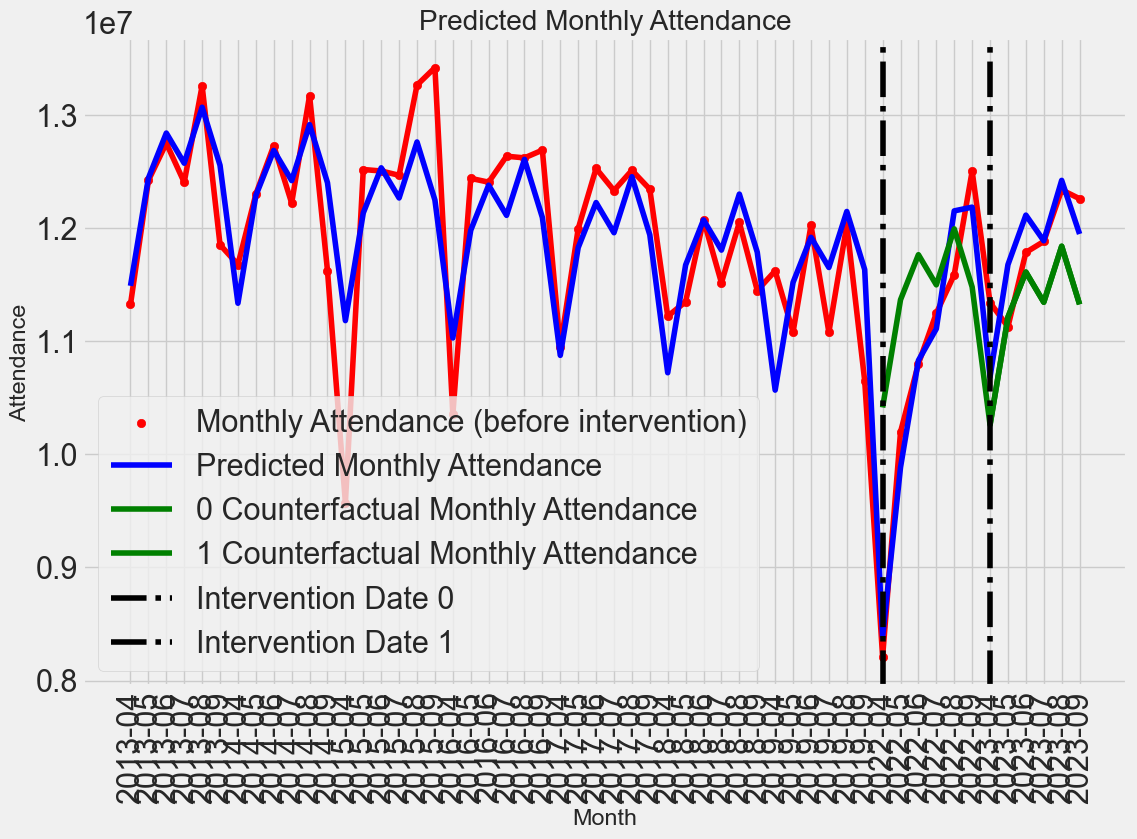

In [10]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

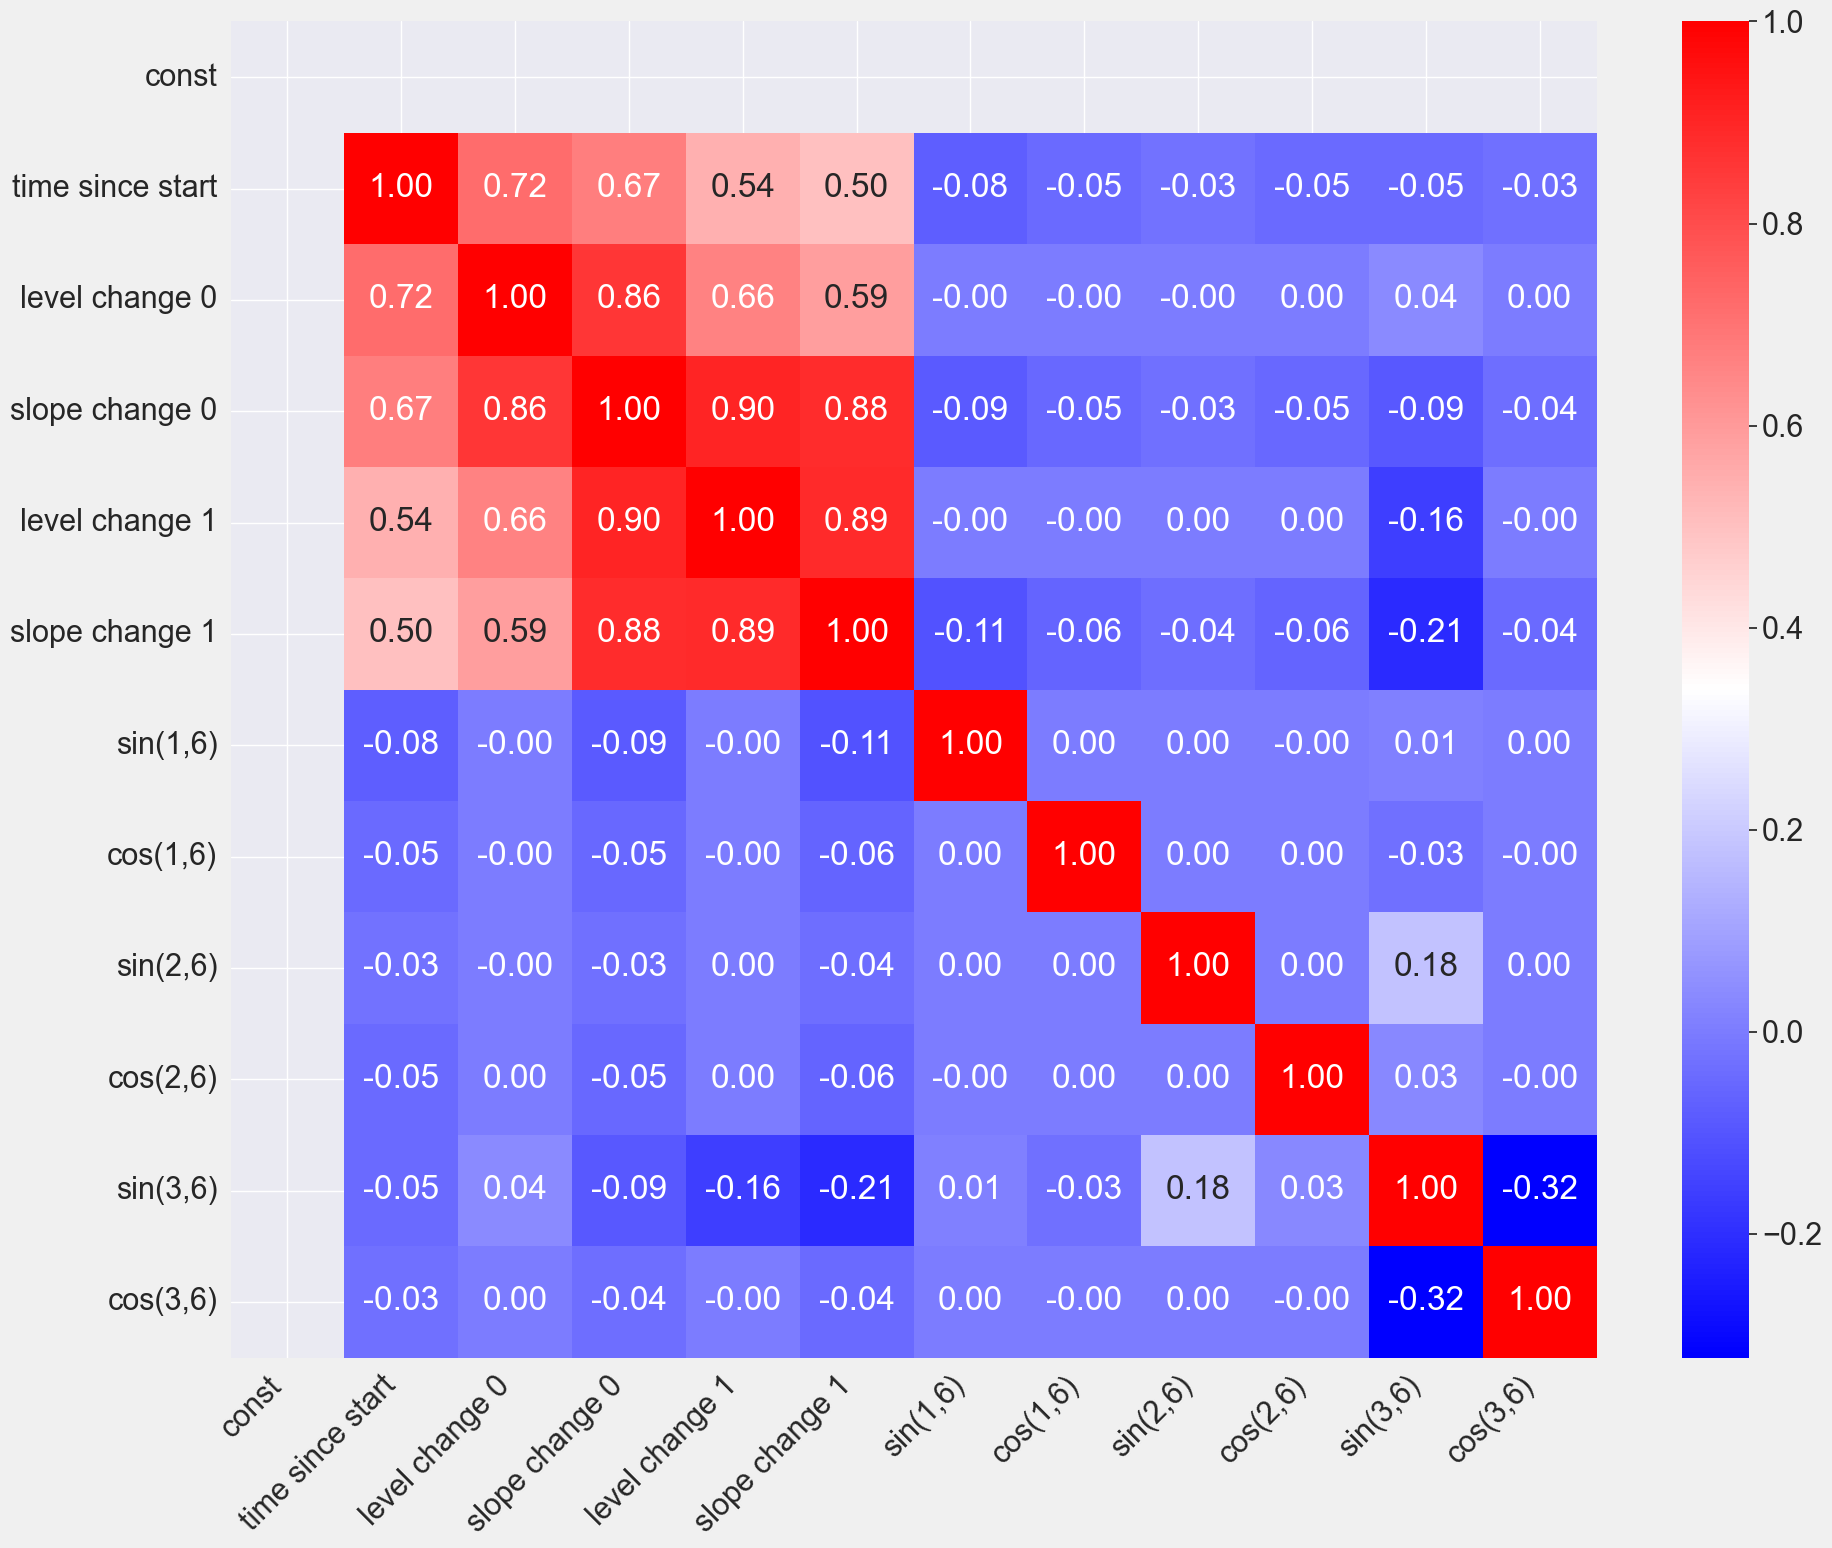

VIF: [5.412946428571427, 2.190380489026994, 10.133333333333342, 35.09115646258506, 9.014965986394559, 9.46666666666666, 1.1603316326530602, 1.0534438775510209, 1.01781462585034, 1.0534438775510209, 1.319814379516164, 1.0267219387755102]


In [11]:
its_periodical_OLS.show_correlation()

多重共線性えぐいやん。てか当たり前か笑

In [12]:
its_periodical_OLS.fit_slope_after_intervention()

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     8.344
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           9.79e-06
Time:                        16:00:13   Log-Likelihood:                -802.31
No. Observations:                  54   AIC:                             1617.
Df Residuals:                      48   BIC:                             1629.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [23]:
# 使うDFを変える
df_att_remove_covid = Att_Analysis(is_remove_covid=True, is_addup=False).df_monthly_att_all_covid_removed
its_periodical_OLS = ITS(df_att_remove_covid, intervention='2023-04', method='Periodic OLS', period=8, order=3)
its_periodical_OLS.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.240
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.288
Time:                        18:01:35   Log-Likelihood:                -1211.9
No. Observations:                  73   AIC:                             2444.
Df Residuals:                      63   BIC:                             2467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.075e+07   1.03e+06     10.442      0.000     8.7e+06    1.28e+07
time since start -2.924e+04   2.74e+04     -1.069      0.289   -8.39e+04    2.54e+04
level change       4.51e+06    3.2e+06      1.411      0.163   -1.88e+06    1.09e+07
slope change     -1.063e+06   8.45e+05     -1.258      0.213   -2.75e+06    6.25e+05
sin(1,8)         -1.321e+06   7.24e+05     -1.826      0.073   -2.77e+06    1.25e+05
sin(2,8)          1.109e+06   7.05e+05      1.572      0.121   -3.01e+05    2.52e+06
sin(3,8)           3.14e+05   7.05e+05      0.445      0.658   -1.09e+06    1.72e+06
cos(1,8)         -5.582e+05   7.13e+05     -0.783      0.436   -1.98e+06    8.66e+05
cos(2,8)         -6.591e+05      7e+05     -0.941      0.350   -2.06e+06     7.4e+05
cos(3,8)           -6.1e+05   6.96e+05     -0.877      0.384      -2e+06    7.81e+05
==============================================================================
Omnibus:                       13.868   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.864
Skew:                          -1.133   Prob(JB):                     0.000359
Kurtosis:                       3.284   Cond. No.                         277.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

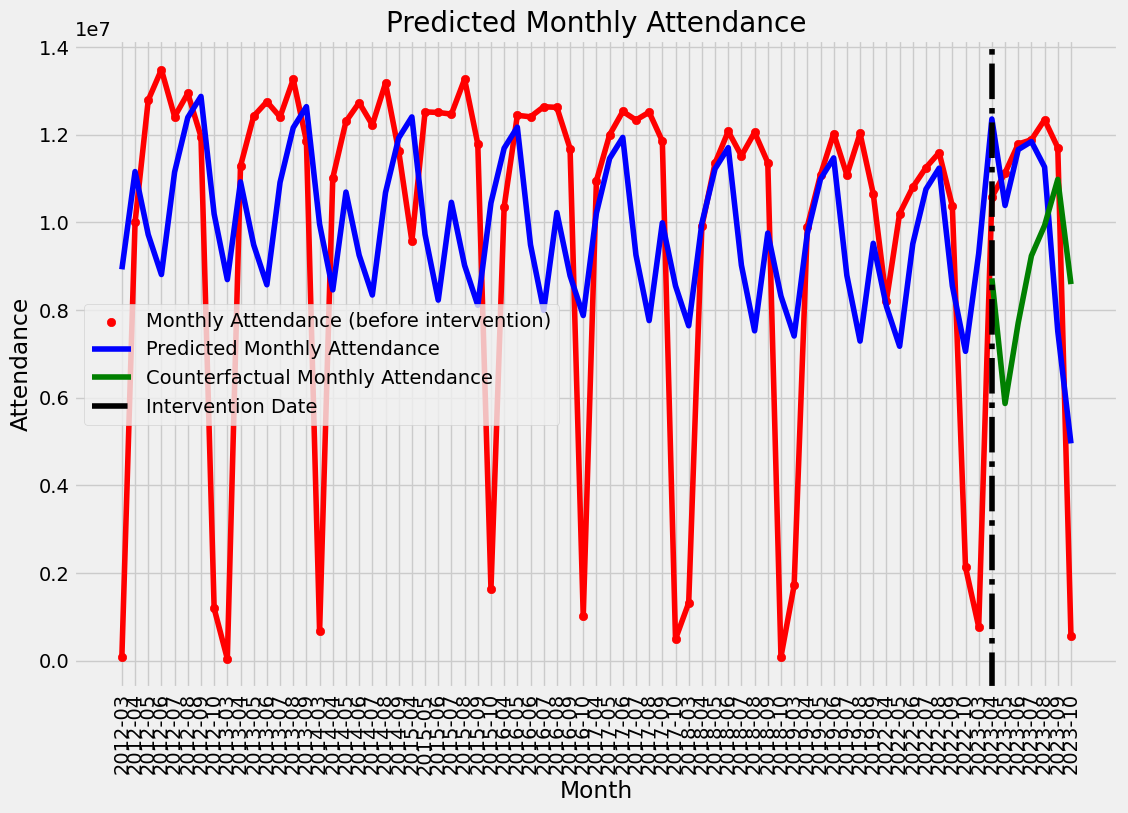

In [24]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [6]:
## 多重共線性の確認
X = its_periodical_OLS.X
X = sm.add_constant(X)
X

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

its_periodical_OLS.plot_predict(is_counterfactual=True, is_prediction_std=True)

its_periodical_OLS.show_summary()


AttributeError: 'MITS' object has no attribute 'X'

## SARIMAXで中断時系列分析


In [3]:
its_sarimax = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=8)

In [4]:
its_sarimax.show_summary()

seed値:8


/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(0, 2, 3)x(3, 2, 3, 6)   Log Likelihood                -626.778
Date:                           Sat, 11 Nov 2023   AIC                           1279.555
Time:                                   00:05:45   BIC                           1301.511
Sample:                                        0   HQIC                          1287.494
                                            - 54                                         
Covariance Type:                             opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
time since start  2.392e-07   2.72e+04   8.81e-12      1.000   -5.32e+04    5.32e+04
level change 0    8.626e+06     60.491   1.43e+05      0.000    8.63e+06    8.63e+06
slope change 0   -7.799e+06     48.291  -1.61e+05      0.000    -7.8e+06    -7.8e+06
ma.L1               -0.4147      0.400     -1.036      0.300      -1.199       0.370
ma.L2                0.3014      0.770      0.392      0.695      -1.207       1.810
ma.L3               -0.0583      0.458     -0.127      0.899      -0.956       0.839
ar.S.L6              0.6874      0.697      0.986      0.324      -0.679       2.054
ar.S.L12            -0.5981      1.698     -0.352      0.725      -3.926       2.729
ar.S.L18            -0.2372      0.529     -0.448      0.654      -1.274       0.800
ma.S.L6             -1.6639      0.877     -1.896      0.058      -3.384       0.056
ma.S.L12             1.3558      1.671      0.811      0.417      -1.919       4.631
ma.S.L18            -0.4666      2.010     -0.232      0.816      -4.405       3.472
sigma2            3.795e+12      0.000   3.65e+16      0.000     3.8e+12     3.8e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.98   Prob(JB):                         0.58
Heteroskedasticity (H):               2.00   Skew:                             0.40
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+33. Standard errors may be unstable.
"""

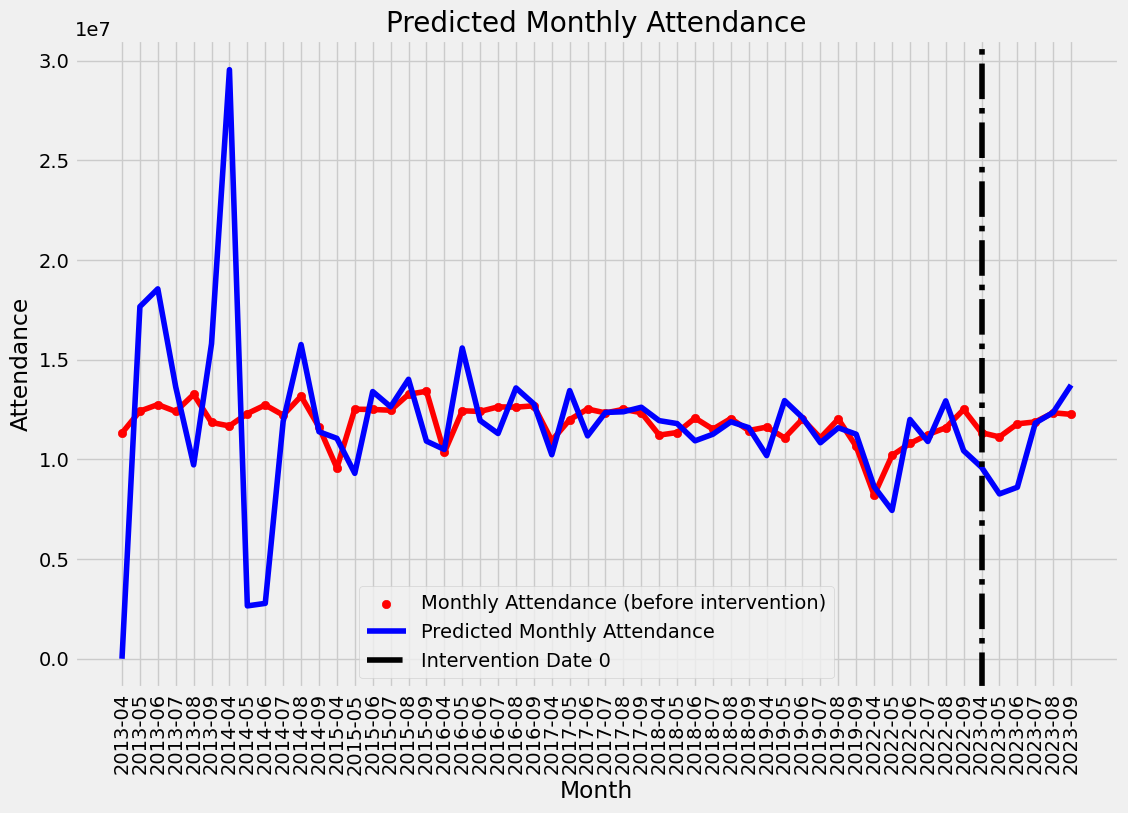

In [6]:
its_sarimax.plot_predict()

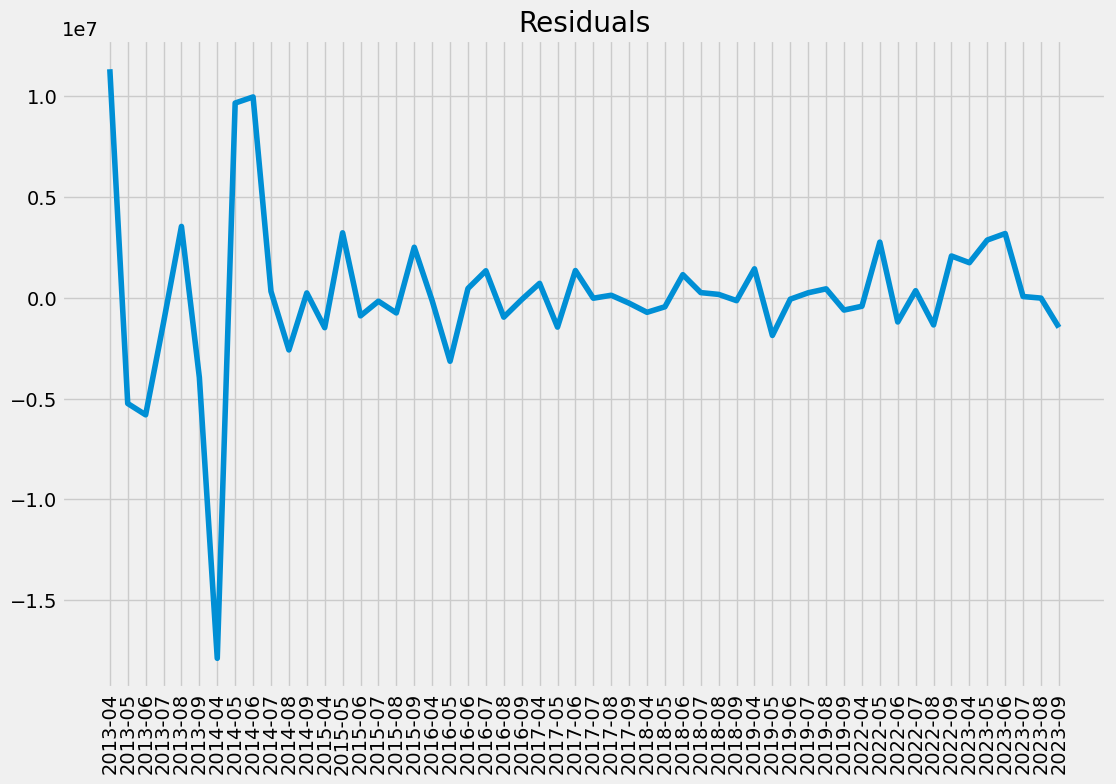

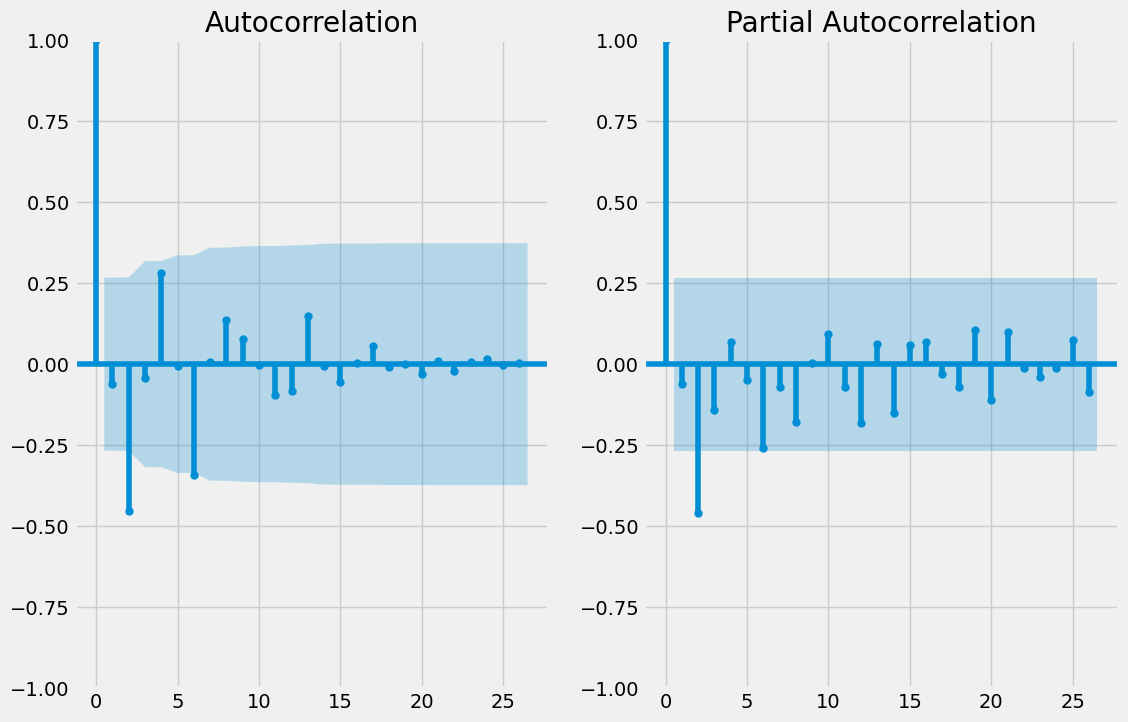

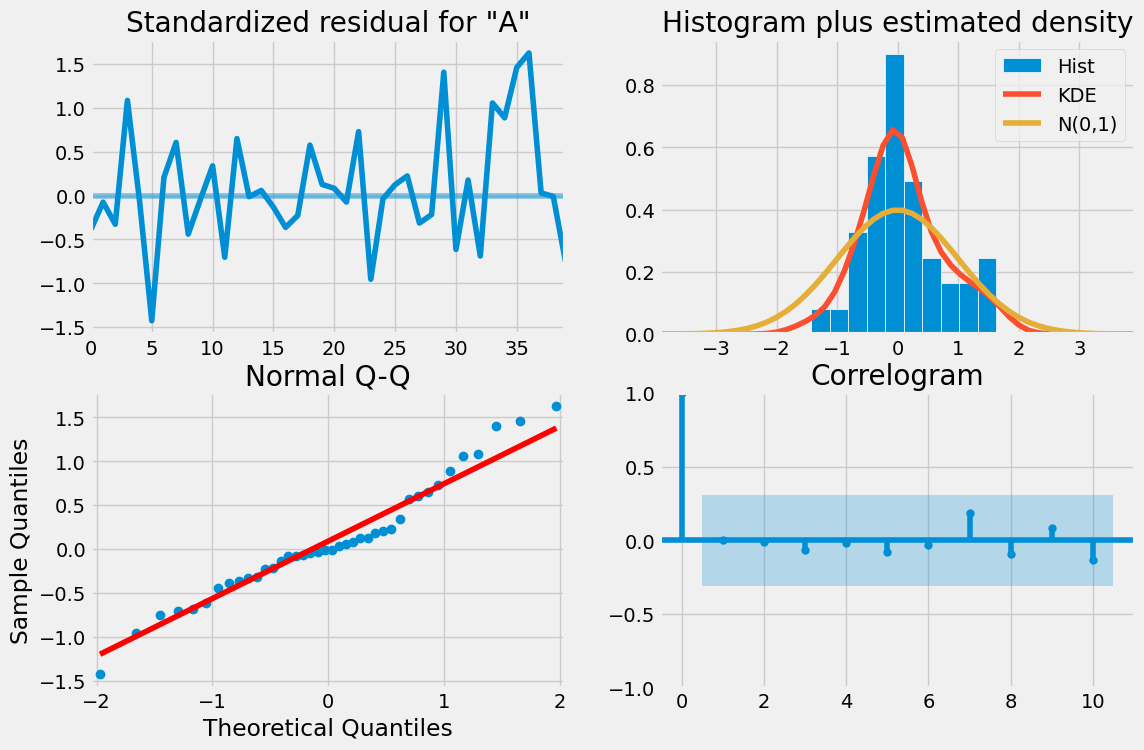

In [7]:
its_sarimax.plot_sarimax_params()

## ARIMAXで中断時系列分析

In [16]:
its_sarimax = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='ARIMAX', optim_params_arimax=True)
its_sarimax.show_summary()

seed値:0


/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                   54
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -810.045
Date:                Sun, 12 Nov 2023   AIC                           1636.090
Time:                        17:28:55   BIC                           1651.700
Sample:                             0   HQIC                          1642.074
                                 - 54                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
time since start    -0.0092      3.397     -0.003      0.998      -6.668       6.650
level change 0   -9.501e+05      2.255  -4.21e+05      0.000    -9.5e+05    -9.5e+05
slope change 0    -1.13e+06     13.719  -8.23e+04      0.000   -1.13e+06   -1.13e+06
ar.L1               -0.6438      0.098     -6.545      0.000      -0.837      -0.451
ar.L2                0.2863      0.084      3.401      0.001       0.121       0.451
ma.L1             4.698e-07   8733.347   5.38e-11      1.000   -1.71e+04    1.71e+04
ma.L2               -1.0000      0.147     -6.811      0.000      -1.288      -0.712
sigma2            1.359e+12   6.43e-09   2.12e+20      0.000    1.36e+12    1.36e+12
===================================================================================
Ljung-Box (L1) (Q):                   3.52   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.06   Prob(JB):                         0.99
Heteroskedasticity (H):               0.42   Skew:                            -0.05
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.48e+40. Standard errors may be unstable.
"""

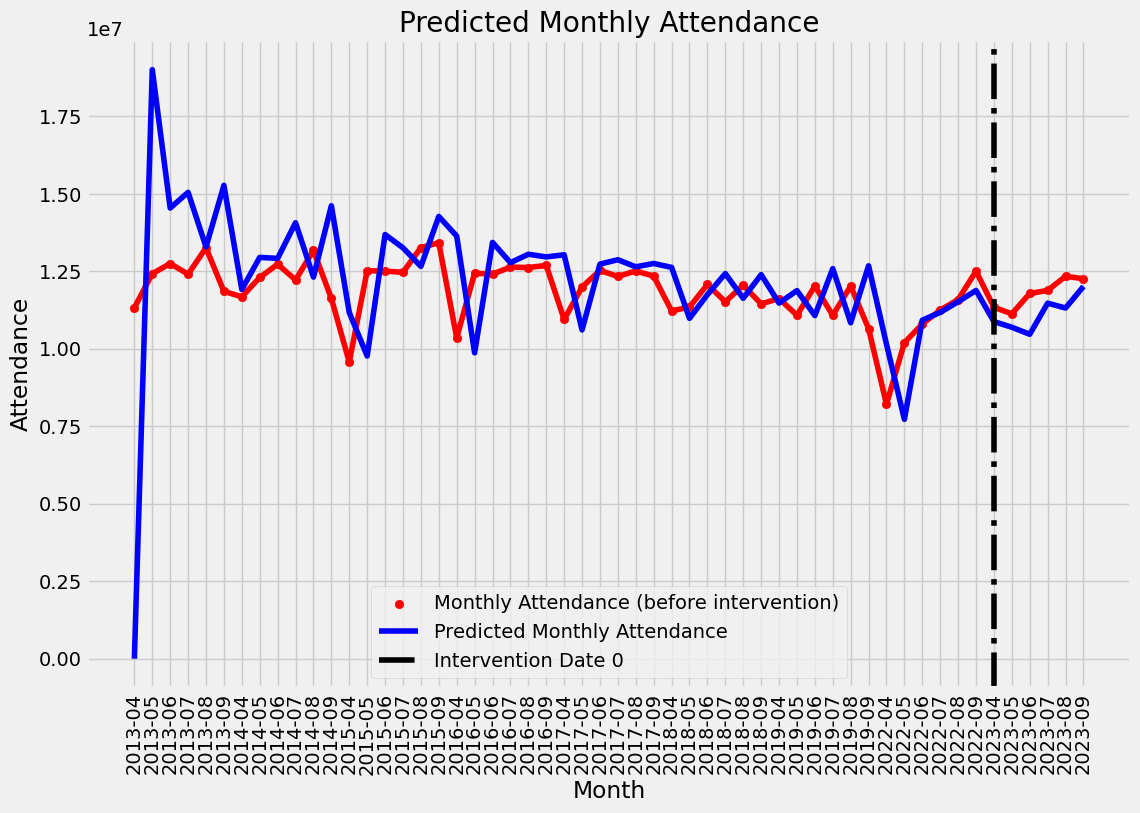

In [18]:
its_sarimax.plot_predict()


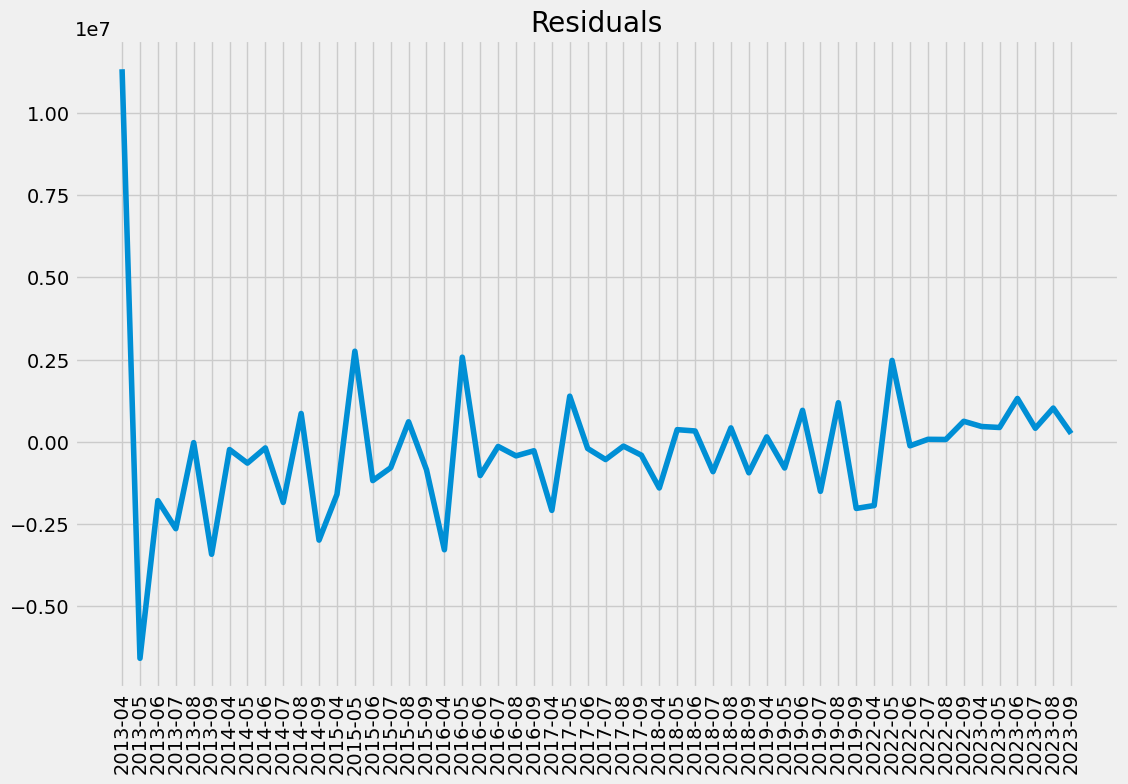

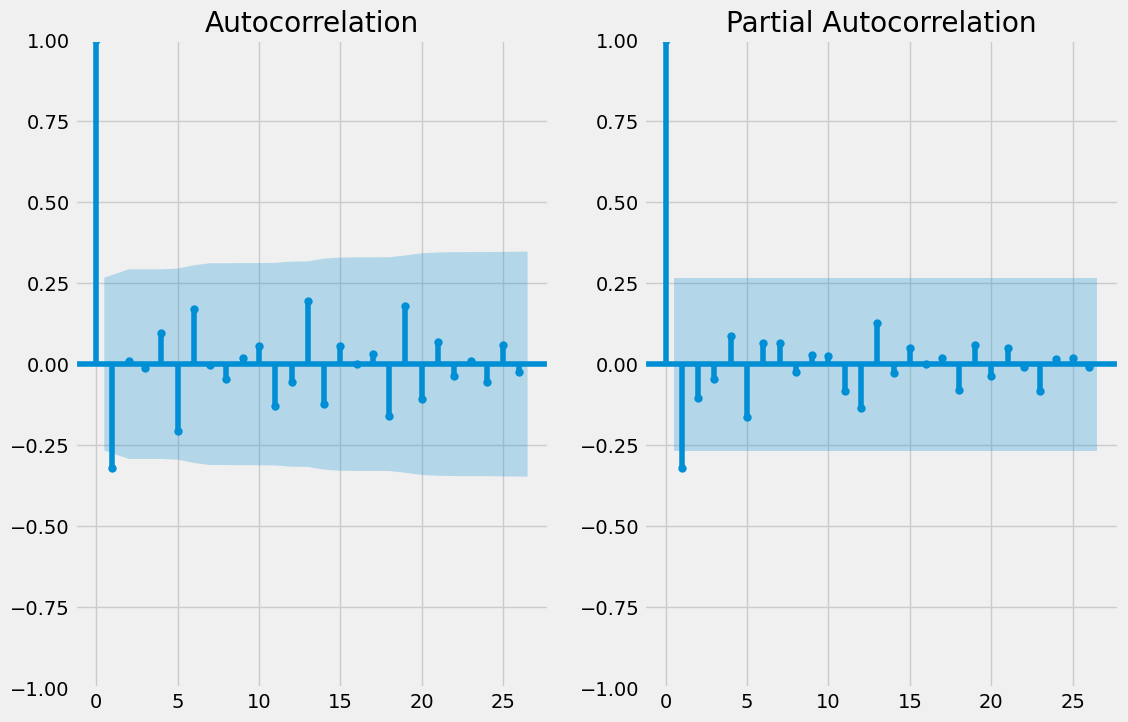

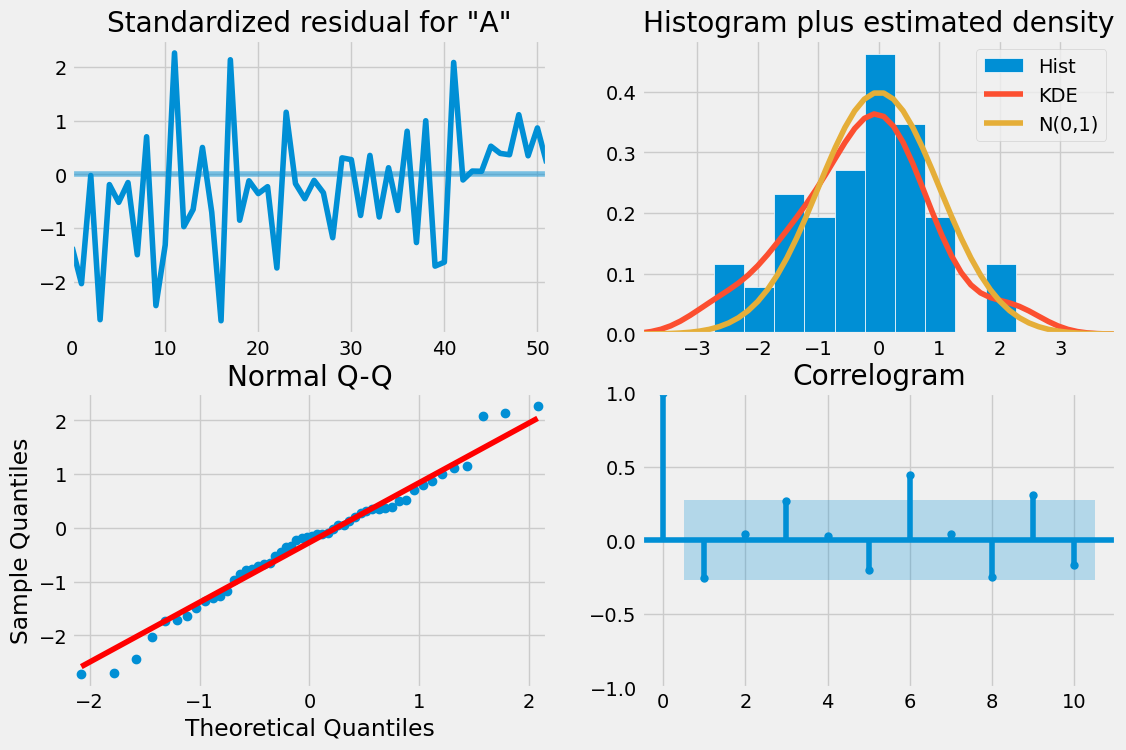

In [19]:
its_sarimax.plot_sarimax_params()
